# Taming chaos in reservoir networks with FORCE learning

This notebook shows a reimplementation of the reservoir network using FORCE learning of the recurrent weights by Laje & Buonomano:

> Laje, R., and Buonomano, D.V. (2013). Robust timing and motor patterns by taming chaos in recurrent neural networks. Nature Neuroscience 16, 925–933.

The goal is to better understand how the network works, what are the limits, in order to be able to apply it to a robotic task later.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Below is the class representing the network, based on the [Re]implementation published here:

> Vitay, J. (2016). [Re] Robust Timing And Motor Patterns By Taming Chaos In Recurrent Neural Networks. ReScience 2.

The network can take `Ni` inputs, has `N` recurrent neurons and `No` output neurons. Each recurrent neuron follows the standard RC equation:

$$
    \tau \cdot \frac{d x_i(t)}{dt} + x_i(t) = \sum_{j=1}^{N_i} W_{ij}^{in} \cdot I_j(t) + \sum_{j=1}^{N} W_{ij}^{rec} \cdot r_j(t) + I^{noise}_i(t)
$$

$$
    r_i(t) = \tanh(x_i(t))
$$

The input weights $W^{in}$ are randomly taken from the standard normal distribution $\mathcal{N}(0, 1)$.

The recurrent weights $W^{rec}$ are sparse (two neurons have a probability `pc=0.1` to be connected) and initialized using the normal distribution $\mathcal{N}(0, \frac{g^2}{pc \, N})$, where $g$ is the scaling factor determining the dynamics of the network. In the implementation, the sparseness of the connectivity matrix is realized using a connectivity mask that multiplies the non existing weights with 0.

The readout neurons simply multiply the activity in the reservoir with the readout weights $W^{out}$ (initially sampled from $\mathcal{N}(0, \frac{1}{N})$) at each time step:

$$
    z_i(t) = \sum_{j=1}^{N} W_{ij}^{out} \cdot r_j(t)
$$

The method `step()` implements these equations, based on an input `I` which has to be of shape `(Ni, 1)` (vector notation). Note that the Euler numerical method is used for the ordinary differential equation. Additive noise can be switched on and off using the corresponding flag.

Both recurrent and readout weights can be learned using the **recursive least squares** (RLS) algorithm for FORCE learning. In Laje & Buonomano, the recurrent weights are trained first to consistently reproduce a desired trajectory $R_i(t)$. Afterwards, the readout weights are trained to reproduce any kind of signal.

To train the recurrent weights, a first trial is amde and the activity of all recurrent neurons is recorded for a fixed duration. This allows later to compute an error signal for all recurrent neurons:

$$
    e_i(t) = r_i(t) - R_i(t)
$$

At each time step, the recurrent weight $w_{ij}$ (from neuron $j$ to neuron $i$) is updated depending on the error and the **inverse correlation matrix** $P^i$ of the recurrent inputs $\mathcal{B}(i)$ to the neuron $i$:

$$
    \Delta w_{ij} = - e_i \sum_{k \in \mathcal{B}(i)} P^i_{jk} \cdot r_k
$$

The inverse correlation matrix $P$ is initialized to the diagonal matrix and updated at each time step with the following rule:

$$
    \Delta P^i_{jk} = - \frac{\sum_{m \in \mathcal{B}(i)} \sum_{n \in \mathcal{B}(i)} P^i_{jm} \cdot r_m \cdot r_n \cdot P^i_{nk} }{ 1 + \sum_{m \in \mathcal{B}(i)} \sum_{n \in \mathcal{B}(i)} r_m \cdot P^i_{mn} \cdot r_n}
$$

The RLS learning rule is implemented in the `train_recurrent()` method, which takes a target signal of shape `(N, 1)` as input. A similar procedure for the readout weights is implemented in `train_readout()`. 

**Q:** Read and understand the `RecurrentNetwork` class.

In [3]:
class RecurrentNetwork(object):
    """
    Class implementing a recurrent network with readout weights and RLS learning rules.

    **Parameters:**

    * `Ni` : Number of input neurons
    * `N` : Number of recurrent neurons
    * `No` : Number of read-out neurons
    * `tau` : Time constant of the neurons
    * `g` : Synaptic strength scaling
    * `pc` : Connection probability
    * `Io` : Noise variance
    * `P_plastic` : Percentage of neurons receiving plastic synapses
    """
    def __init__(self, Ni=2, N=800, No=1, tau=10.0, g=1.5, pc=0.1, Io=0.001, delta=1.0, P_plastic=0.6):
        
        # Copy the parameters
        self.Ni = Ni
        self.N = N
        self.No = No
        self.tau = tau
        self.g = g
        self.pc = pc
        self.Io = Io
        self.P_plastic = P_plastic
        self.N_plastic = int(self.P_plastic*self.N) # Number of plastic cells = 480

        # Input
        self.I = np.zeros((self.Ni, 1))

        # Recurrent population
        self.x = np.random.uniform(-1.0, 1.0, (self.N, 1))
        self.r = np.tanh(self.x)

        # Read-out population
        self.z = np.zeros((self.No, 1))

        # Weights between the input and recurrent units
        self.W_in = np.random.randn(self.N, self.Ni)

        # Weights between the recurrent units
        self.W_rec = (np.random.randn(self.N, self.N) * self.g/np.sqrt(self.pc*self.N))

        # The connection pattern is sparse with p=0.1
        connectivity_mask = np.random.binomial(1, self.pc, (self.N, self.N))
        connectivity_mask[np.diag_indices(self.N)] = 0
        self.W_rec *= connectivity_mask

        # Store the pre-synaptic neurons to each plastic neuron
        self.W_plastic = [list(np.nonzero(connectivity_mask[i, :])[0]) for i in range(self.N_plastic)]

        # Inverse correlation matrix of inputs for learning recurrent weights
        self.P = [np.identity(len(self.W_plastic[i])) for i in range(self.N_plastic)]

        # Output weights
        self.W_out = (np.random.randn(self.No, self.N) / np.sqrt(self.N))

        # Inverse correlation matrix of inputs for learning readout weights
        self.P_out = [np.identity(self.N) for i in range(self.No)]
        
    def reinitialize_readout_weights(self):
        "Reinitializes the readout weights while preserving the recurrent weights."

        # Output weights
        self.W_out = (np.random.randn(self.No, self.N) / np.sqrt(self.N))

        # Inverse correlation matrix of inputs for learning readout weights
        self.P_out = [np.identity(self.N) for i in range(self.No)]
        
    def reset(self):
        """
        Resets the activity in the network.
        """    
        self.x = np.random.uniform(-1.0, 1.0, (self.N, 1))
        self.r = np.tanh(self.x)
        self.z = np.zeros((self.No, 1))

    def step(self, I, noise=True):
        """
        Updates neural variables for a single simulation step.
        
        * `I`: input at time t, numpy array of shape (Ni, 1)
        * `noise`: if noise should be added to the recurrent neurons dynamics (should be False when recording the initial trajectory).
        """
        
        # Noise can be shut off
        I_noise = (self.Io * np.random.randn(self.N, 1) if noise else 0.0)
        
        # tau * dx/dt + x = I + W_rec * r + I_noise
        self.x += (np.dot(self.W_in, I) + np.dot(self.W_rec, self.r) + I_noise - self.x)/self.tau
        
        # r = tanh(x)
        self.r = np.tanh(self.x)
        
        # z = W_out * r
        self.z = np.dot(self.W_out, self.r)

    def train_recurrent(self, target):
        """
        Applies the RLS learning rule to the recurrent weights.
        
        * `target`: desired trajectory at time t, numpy array of shape (N, 1)
        """
        # Compute the error of the recurrent neurons
        error = self.r - target

        # Apply the FORCE learning rule to the recurrent weights
        for i in range(self.N_plastic): # for each plastic post neuron
            
            # Get the rates from the plastic synapses only
            r_plastic = self.r[self.W_plastic[i]]
            
            # Multiply the inverse correlation matrix P*R with the rates from the plastic synapses only
            PxR = np.dot(self.P[i], self.r[self.W_plastic[i]])
            
            # Normalization term 1 + R'*P*R
            RxPxR = (1. + np.dot(r_plastic.T,  PxR))
            
            # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
            self.P[i] -= np.dot(PxR, PxR.T)/RxPxR
            
            # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
            self.W_rec[i, self.W_plastic[i]] -= error[i, 0] * (PxR/RxPxR)[:, 0]

    def train_readout(self, target):
        """
        Applies the RLS learning rule to the readout weights.
        
        * `target`: desired output at time t, numpy array of shape (No, 1)
        """
        # Compute the error of the output neurons
        error = self.z - target

        # Apply the FORCE learning rule to the readout weights
        for i in range(self.No): # for each readout neuron
            
            # Multiply the rates with the inverse correlation matrix P*R
            PxR = np.dot(self.P_out[i], self.r)
            
            # Normalization term 1 + R'*P*R
            RxPxR = (1. + np.dot(self.r.T,  PxR))
            
            # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
            self.P_out[i] -= np.dot(PxR, PxR.T)/RxPxR
            
            # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
            self.W_out[i, :] -= error[i, 0] * (PxR/RxPxR)[:, 0]



We can now build the network with default parameters: 2 inputs, 800 neurons, 1 output. The scaling factor `g=1.5` ensures dynamics at the **edge of chaos**.

In [4]:
Ni = 2 # Number of inputs
N = 800 # Number of recurrent neurons
No = 1 # Number of read-out neurons
tau = 10.0 # Time constant of the neurons
g = 1.5 # Synaptic strength scaling
pc = 0.1 # Connection probability
Io = 0.001 # Noise variance
P_plastic = 0.6 # Percentage of neurons receiving plastic synapses

In [5]:
net = RecurrentNetwork(
    Ni = Ni, # Number of inputs
    N = N, # Number of recurrent neurons
    No = No, # Number of read-out neurons
    tau = tau, # Time constant of the neurons
    g = g, # Synaptic strength scaling
    pc = pc, # Connection probability
    Io = Io, # Noise variance
    P_plastic = P_plastic, # Percentage of neurons receiving plastic synapses
)

**Q:** Visualize the recurrent connectivity matrix `net.W_rec` with `plt.imshow`. For readability, only visualize the connections between the first 100 neurons or so.

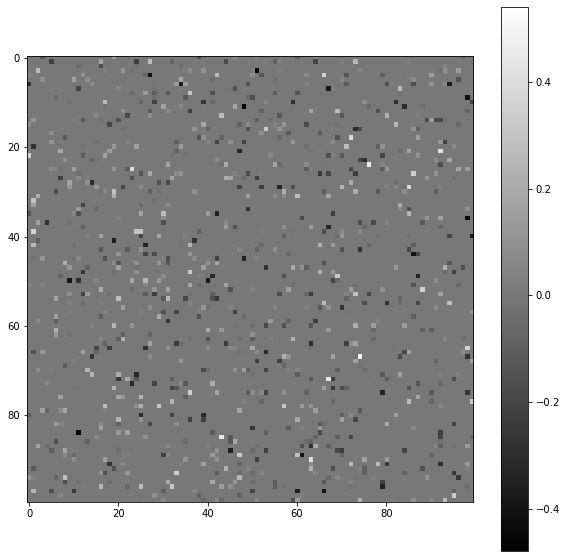

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(net.W_rec[:100, :100], cmap="gray")
plt.colorbar()

Let's now define a short impulse between 50 ms and 100 ms for the two input neurons, for a total duration of 1000 ms:

In [7]:
# Inputs
trial_duration = 1000
t_start = 100

impulse1 = np.zeros((trial_duration, Ni, 1))
impulse1[t_start - 50:t_start, 0, :] = 2.0 

impulse2 = np.zeros((trial_duration, Ni, 1))
impulse2[t_start - 50:t_start, 1, :] = 2.0 

**Q:** Plot the impulses.

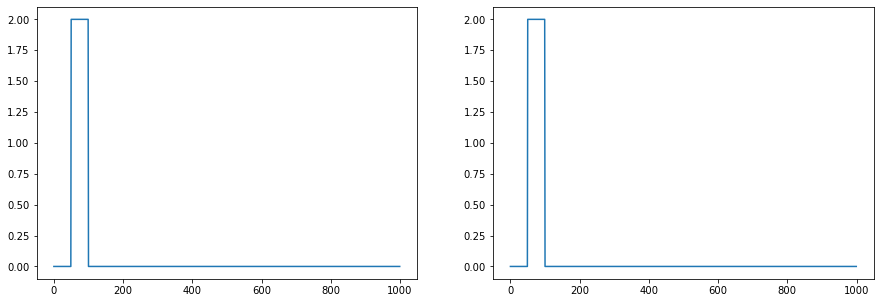

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(impulse1[:, 0, 0])
plt.subplot(122)
plt.plot(impulse2[:, 1, 0])

Let's now provide the first impulse to the network by simulating 1000 time steps (=ms). We record the activity of the recurrent and readout neurons in numpy arrays: we will use this first run as a target for training later. Note that noise is disabled in this first run.
The following cell displays the activity of the first 100 cells, as well as the detailed timecourse of three recurrent neurons and the readout neuron.

In [9]:
# Recording
trajectory1 = []
output1 = []

# Reset the network
net.reset()

# Iterate over the trial duration
for t in range(trial_duration):
    net.step(impulse1[t, :, :], noise=False)
    trajectory1.append(net.r)
    output1.append(net.z)
    
trajectory1 = np.array(trajectory1)
output1 = np.array(output1)

Text(0, 0.5, 'Output z')

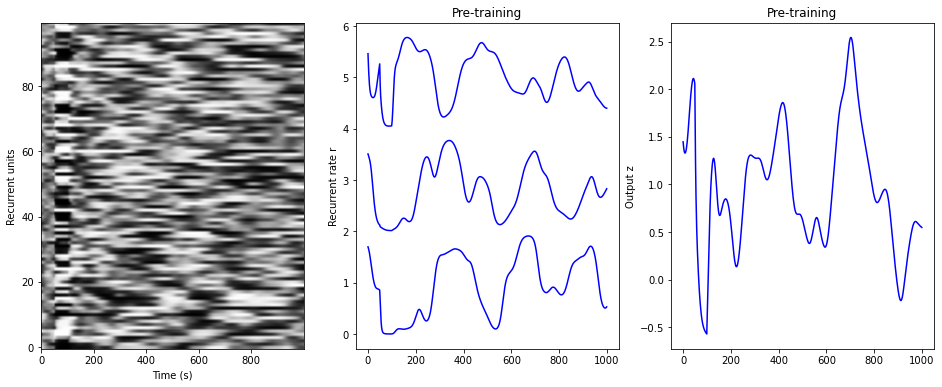

In [10]:
fig = plt.figure(figsize=(12, 6))

ax = plt.subplot(131)
ax.imshow(trajectory1[:, :100, 0].T, aspect='auto', origin='lower', cmap="gray")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(132)
ax.plot(trajectory1[:, 0, 0] + 1, 'b')
ax.plot(trajectory1[:, 1, 0] + 3, 'b')
ax.plot(trajectory1[:, 2, 0] + 5, 'b')
ax.set_title('Pre-training')
ax.set_ylabel('Recurrent rate r')

ax = plt.subplot(133)
ax.plot(output1[:, 0, 0] + 1, 'b')
ax.set_title('Pre-training')
ax.set_ylabel('Output z')

**Q:** Do another trial, this time with noise. Do not overwrite `trajectory1`. Make a plot that superposes the two runs. What do you observe? Do not hesitate to run longer simulations to see what happens. or to swicth noise off.

In [11]:
trajectory = []
output = []

# Reset the network
net.reset()

# Iterate over the trial duration
for t in range(trial_duration):
    net.step(impulse1[t, :, :], noise=True)
    trajectory.append(net.r)
    output.append(net.z)
    
trajectory = np.array(trajectory)
output = np.array(output)

Text(0, 0.5, 'Recurrent rate')

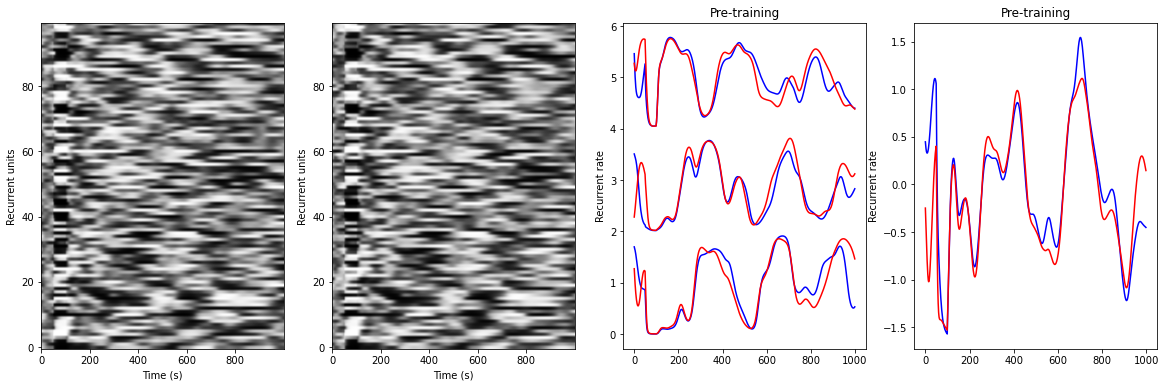

In [12]:
fig = plt.figure(figsize=(20, 6))

ax = plt.subplot(141)
ax.imshow(trajectory1[:, :100, 0].T, aspect='auto', origin='lower', cmap="gray")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(142)
ax.imshow(trajectory[:, :100, 0].T, aspect='auto', origin='lower', cmap="gray")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(143)
ax.plot(trajectory1[:, 0, 0] + 1, 'b')
ax.plot(trajectory1[:, 1, 0] + 3, 'b')
ax.plot(trajectory1[:, 2, 0] + 5, 'b')
ax.plot(trajectory[:, 0, 0] + 1, 'r')
ax.plot(trajectory[:, 1, 0] + 3, 'r')
ax.plot(trajectory[:, 2, 0] + 5, 'r')
ax.set_title('Pre-training')
ax.set_ylabel('Recurrent rate')

ax = plt.subplot(144)
ax.plot(output1[:, 0, 0], 'b')
ax.plot(output[:, 0, 0], 'r')
ax.set_title('Pre-training')
ax.set_ylabel('Recurrent rate')

The network is at the edge of chaos: the small (0.001) added noise is enough to make the trajectories diverge after a while.

Let's now train the recurrent weights to stabilize the trajectories. We will do 30 different trials with noise, with a call to `net.reset()` at the start of each trial. 

After each call to `step()` done after 100 ms (i.e. after the end of the impulse), you will call `net.train_recurrent(target=trajectory1[t, :, :])` by passing the recorded activity at time $t$ during the first recorded trial. 

Beware: training is extremely expensive, as RLS requires matrix multiplications for each neuron. It is possible to call `net.train_recurrent()` only every 5 steps to save computations without impacting performance too much (`if t%5==0`). 

**Q:** Train the recurrent weights for 30 trials to reproduce the trajectory `trajectory1`. After training, do a test trial and superpose it to `trajectory1`. What do you observe?

In [13]:
# Learning for the recurrent weights
for trial in range(30):
    print('Learning trial for the recurrent weights', trial+1)
    
    # Reset the network
    net.reset()

    # Iterate over the trial duration
    for t in range(trial_duration):
        
        net.step(impulse1[t, :, :], noise=True)
        
        if t > t_start and t%5==0:
            net.train_recurrent(target=trajectory1[t, :, :])

Learning trial for the recurrent weights 1
Learning trial for the recurrent weights 2
Learning trial for the recurrent weights 3
Learning trial for the recurrent weights 4
Learning trial for the recurrent weights 5
Learning trial for the recurrent weights 6
Learning trial for the recurrent weights 7
Learning trial for the recurrent weights 8
Learning trial for the recurrent weights 9
Learning trial for the recurrent weights 10
Learning trial for the recurrent weights 11
Learning trial for the recurrent weights 12
Learning trial for the recurrent weights 13
Learning trial for the recurrent weights 14
Learning trial for the recurrent weights 15
Learning trial for the recurrent weights 16
Learning trial for the recurrent weights 17
Learning trial for the recurrent weights 18
Learning trial for the recurrent weights 19
Learning trial for the recurrent weights 20
Learning trial for the recurrent weights 21
Learning trial for the recurrent weights 22
Learning trial for the recurrent weights 

In [14]:
trajectory = []
output = []

# Reset the network
net.reset()

# Iterate over the trial duration
for t in range(trial_duration):
    net.step(impulse1[t, :, :], noise=True)
    trajectory.append(net.r)
    output.append(net.z)
    
trajectory = np.array(trajectory)
output = np.array(output)

Text(0, 0.5, 'Recurrent rate')

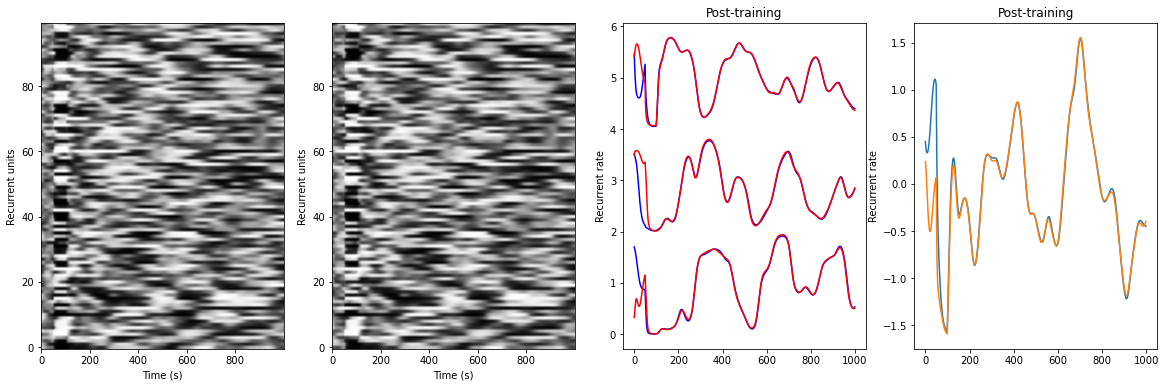

In [15]:
fig = plt.figure(figsize=(20, 6))

ax = plt.subplot(141)
ax.imshow(trajectory1[:, :100, 0].T, aspect='auto', origin='lower', cmap="gray")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(142)
ax.imshow(trajectory[:, :100, 0].T, aspect='auto', origin='lower', cmap="gray")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(143)
ax.plot(trajectory1[:, 0, 0] + 1, 'b')
ax.plot(trajectory1[:, 1, 0] + 3, 'b')
ax.plot(trajectory1[:, 2, 0] + 5, 'b')
ax.plot(trajectory[:, 0, 0] + 1, 'r')
ax.plot(trajectory[:, 1, 0] + 3, 'r')
ax.plot(trajectory[:, 2, 0] + 5, 'r')
ax.set_xlabel('Time (s)')
ax.set_title('Post-training')
ax.set_ylabel('Recurrent rate')

ax = plt.subplot(144)
ax.plot(output1[:, 0, 0])
ax.plot(output[:, 0, 0])
ax.set_xlabel('Time (s)')
ax.set_title('Post-training')
ax.set_ylabel('Recurrent rate')

Let's now train the readout weights. We first generate two target signals, a bump 500 ms after the end of the impulse, and a sine function. You can be creative and define other signals if you want.

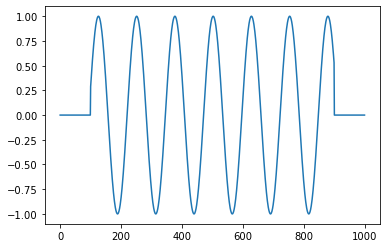

In [16]:
t = np.linspace(0, trial_duration, trial_duration)

# Bump target output
bump = np.zeros((trial_duration, No, 1))
bump[:, 0, 0] = 0.2 + 0.8 * np.exp(-(t - 600)**2/(30)**2)

# Cosine target output
cosine_fct = np.zeros((trial_duration, No, 1))
cosine_fct[100:, 0, 0] = np.cos(t[100:]/20)
cosine_fct[900:, 0, 0] = 0.

# Select which target signal to use
target = cosine_fct
#target = bump

plt.plot(target[:, 0, 0])

**Q:** Train the readout weights to reproduce one of the target signals for 10 trials. The only difference with the previous training phase is that you will call `net.train_readout()`. Do a test trial and visualize the output. Does it work? Reset the readout weights with `net.reinitialize_readout_weights()` and learn the other signal.

In [17]:
net.reinitialize_readout_weights()

# Learning for the readout weights
for trial in range(10):
    print('Learning trial for the readout weights', trial+1)
    
    # Reset the network
    net.reset()

    # Iterate over the trial duration
    for t in range(trial_duration):
        
        net.step(impulse1[t, :, :], noise=True)
        
        if t > t_start and t%5==0:
            net.train_readout(target=target[t, :, :])

Learning trial for the readout weights 1
Learning trial for the readout weights 2
Learning trial for the readout weights 3
Learning trial for the readout weights 4
Learning trial for the readout weights 5
Learning trial for the readout weights 6
Learning trial for the readout weights 7
Learning trial for the readout weights 8
Learning trial for the readout weights 9
Learning trial for the readout weights 10


In [18]:
trajectory = []
output = []

# Reset the network
net.reset()

# Iterate over the trial duration
for t in range(trial_duration):
    net.step(impulse1[t, :, :], noise=True)
    trajectory.append(net.r)
    output.append(net.z)
    
trajectory = np.array(trajectory)
output = np.array(output)

Text(0, 0.5, 'Recurrent rate')

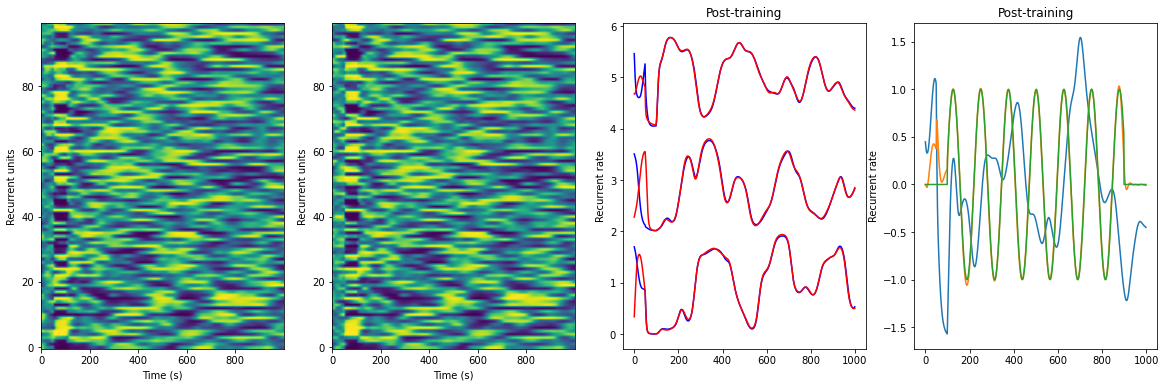

In [19]:
fig = plt.figure(figsize=(20, 6))

ax = plt.subplot(141)
ax.imshow(trajectory1[:, :100, 0].T, aspect='auto', origin='lower')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(142)
ax.imshow(trajectory[:, :100, 0].T, aspect='auto', origin='lower')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(143)
ax.plot(trajectory1[:, 0, 0] + 1, 'b')
ax.plot(trajectory1[:, 1, 0] + 3, 'b')
ax.plot(trajectory1[:, 2, 0] + 5, 'b')
ax.plot(trajectory[:, 0, 0] + 1, 'r')
ax.plot(trajectory[:, 1, 0] + 3, 'r')
ax.plot(trajectory[:, 2, 0] + 5, 'r')
ax.set_xlabel('Time (s)')
ax.set_title('Post-training')
ax.set_ylabel('Recurrent rate')

ax = plt.subplot(144)
ax.plot(output1[:, 0, 0])
ax.plot(output[:, 0, 0])
ax.plot(target[:, 0, 0])
ax.set_xlabel('Time (s)')
ax.set_title('Post-training')
ax.set_ylabel('Recurrent rate')

To further demonstrate the robustness of the trained dynamics, let's perturb the reservoir by adding a small input to the second input neuron for a short period of time after the initial impulse.

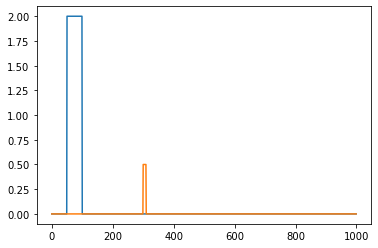

In [20]:
# Small perturbation at t = 300
perturbation = impulse1.copy() 
perturbation[300:310, 1, :] = 0.5 

plt.plot(perturbation[:, 0, 0])
plt.plot(perturbation[:, 1, 0])

**Q:** Do a test trial using this input. Does the network recover its learned dynamics?

In [22]:
trajectory = []
output = []

# Reset the network
net.reset()

# Iterate over the trial duration
for t in range(trial_duration):
    net.step(perturbation[t, :, :], noise=True)
    trajectory.append(net.r)
    output.append(net.z)
    
trajectory = np.array(trajectory)
output = np.array(output)

Text(0, 0.5, 'Recurrent rate')

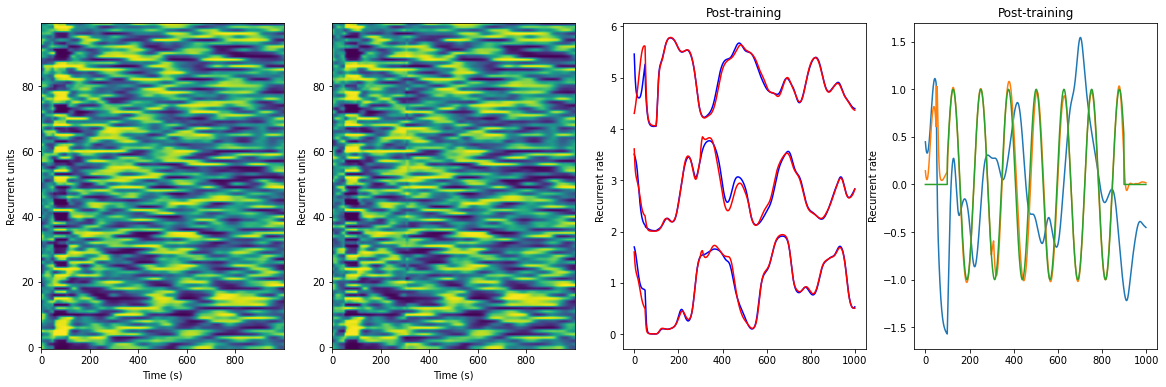

In [23]:
fig = plt.figure(figsize=(20, 6))

ax = plt.subplot(141)
ax.imshow(trajectory1[:, :100, 0].T, aspect='auto', origin='lower')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(142)
ax.imshow(trajectory[:, :100, 0].T, aspect='auto', origin='lower')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Recurrent units')

ax = plt.subplot(143)
ax.plot(trajectory1[:, 0, 0] + 1, 'b')
ax.plot(trajectory1[:, 1, 0] + 3, 'b')
ax.plot(trajectory1[:, 2, 0] + 5, 'b')
ax.plot(trajectory[:, 0, 0] + 1, 'r')
ax.plot(trajectory[:, 1, 0] + 3, 'r')
ax.plot(trajectory[:, 2, 0] + 5, 'r')
ax.set_xlabel('Time (s)')
ax.set_title('Post-training')
ax.set_ylabel('Recurrent rate')

ax = plt.subplot(144)
ax.plot(output1[:, 0, 0])
ax.plot(output[:, 0, 0])
ax.plot(target[:, 0, 0])
ax.set_xlabel('Time (s)')
ax.set_title('Post-training')
ax.set_ylabel('Recurrent rate')

Now experiment freely with the network, for example:

* Train the recurrent weights for less epochs and see if it is still robust to perturbations.
* Try to learn different trajectories for the two impulse signals (you may have to interleave trials with impulse1 and impulse2 during training) and train a single readout neuron (or two?) to learn both target signals depending on the input.
* Have two readout neurons reproduce trajectories in the 2D space, as the examples with "chaos" and "neuron" in the Laje & Buonomano paper.
* Decrease or increase the number of neurons in the reservoir and see what happens to the dynamics.
* Find a meaningful application of this network on the iCub simulator ;)